# ENEM 2022: prelimenary analyses

This is a prelimenary notebook used to identify initial patterns in the dataset, and helping delineate analyses path for the remaining of the project.
___

### Libs importing

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

from preprocess import rename_columns

## Dataset loading and exploration

### Initial dataset loading

At this stage, we will only focus on the ENEM 2022 dataset.

In [3]:
df = pd.read_csv("../Datasets/2022/DADOS/MICRODADOS_ENEM_2022.csv", sep = ';', encoding = 'latin1')

In [5]:
df.head()

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,210057943671,2022,14,M,2,2,1,1,2,1,...,B,A,A,A,A,A,A,A,A,A
1,210057516120,2022,14,M,2,1,1,1,16,1,...,E,E,B,E,B,B,E,B,E,B
2,210057280536,2022,5,F,1,2,1,1,2,1,...,A,A,A,A,A,A,C,A,A,B
3,210055724397,2022,6,M,1,3,1,1,2,1,...,B,A,A,C,A,A,C,B,B,B
4,210055097896,2022,4,M,0,3,1,1,1,1,...,A,A,A,A,A,A,B,A,A,A


In [ ]:
# familiarization with the dataset columns
df.columns

### Initial questions

To begin working with this data, the following are some preliminary questions of interest that should be answered. They should give us a general understanding of a few basic aspects of our data for ENEM 2022.

#### How many students have registered to take the test?

In [6]:
# understanding the number of students and columns in the dataset
df.shape

(3476105, 76)

For the year 2022, ENEM had about 3.5 M students' registrations.

In [7]:
# familiarization with the dataset columns
df.columns

Index(['NU_INSCRICAO', 'NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
       'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC',
       'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA',
       'SG_UF_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'TP_PRESENCA_MT', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC',
       'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC',
       'TX_RESPOSTAS_MT', 'TP_LINGUA', 'TX_GABARITO_CN', 'TX_GABARITO_CH',
       'TX_GABARITO_LC', 'TX_GABARITO_MT', 'TP_STATUS_REDACAO',
       'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004',

In [6]:
# How many students have missed at least one of the tests?
(df[df[['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_MT', 'TP_PRESENCA_LC']].sum(axis = 1) < 4]['TP_PRESENCA_CN'].count())/df.shape[0]

0.3236475883208361

We also see that about 32 % of students missed at least one of the tests in ENEM 2022. These will further be removed from our analysis.

### Which columns and rows will we drop from our analysis?

To help evaluate relevant columns for our outcome (i.e., predicting students' performance), let us investigate the values of a few non-trivial columns.

In [15]:
# is the school still functioning?
df['TP_SIT_FUNC_ESC'].value_counts(normalize = True).rename(index = {1: 'Active',
                                                                     2: 'Paralized',
                                                                     3: 'Extinct',
                                                                     4: 'School was extinct in previous years'})

Active                                  0.992757
School was extinct in previous years    0.003868
Paralized                               0.003004
Extinct                                 0.000371
Name: TP_SIT_FUNC_ESC, dtype: float64

As would be expected, the vast majority (99.3 %) of entries in our database comes from students whose schools were "active" at the time they registered to take the test. We will further filter out inactive schools (which account for about 0.7 % of our data).

In [17]:
# which administrative unity is responsible for that school?
df['TP_DEPENDENCIA_ADM_ESC'].value_counts(normalize = True).rename(index = {1: 'Federal',
                                                                     2: 'State',
                                                                     3: 'Municipality',
                                                                     4: 'Private'})

State           0.699642
Private         0.238902
Federal         0.051948
Municipality    0.009508
Name: TP_DEPENDENCIA_ADM_ESC, dtype: float64

The majority of our database entries comes from State and Private schools. Nonetheless, unlinke for the previous columns, we will not filter out the other entries. 

We will remove columns that are of no interest for us at this point. We shall restrain ourselves at the "STATE" level (i.e., not using city information).

In [4]:
df.drop(columns = ['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_ESC', 'CO_UF_ESC', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_MT', 'CO_PROVA_LC',
                   'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_MT', 'TX_RESPOSTAS_LC', 'TP_LINGUA', 'TX_GABARITO_CN', 'TX_GABARITO_CH',
                   'TX_GABARITO_LC', 'TX_GABARITO_MT', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
                   'NU_NOTA_REDACAO', 'TP_ST_CONCLUSAO', 'IN_TREINEIRO', 'NO_MUNICIPIO_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC',
                   'TP_SIT_FUNC_ESC', 'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA'],
                   inplace = True)

In [5]:
df.shape

(3476105, 44)

Let us also drop students that missed any of the tests, and that had their writing essay nullified for some reason.

In [6]:
df.drop(df[(df['TP_PRESENCA_CN'].isin([0,2])) | (df['TP_PRESENCA_CH'].isin([0,2]))
| (df['TP_PRESENCA_MT'].isin([0,2])) | (df['TP_PRESENCA_LC'].isin([0,2])) 
| (df['TP_STATUS_REDACAO'] != 1)].index, inplace = True)

In [7]:
df.shape

(2245649, 44)

Finally, let us also drop the previous columns, as we will not need them for our analyses.

In [8]:
df.drop(columns = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_MT', 'TP_PRESENCA_LC', 'TP_STATUS_REDACAO'], inplace = True)

In [6]:
df.shape

(2245649, 39)

In [7]:
df.columns

Index(['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_NACIONALIDADE', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO',
       'SG_UF_ESC', 'SG_UF_PROVA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
       'NU_NOTA_MT', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007',
       'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016',
       'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025'],
      dtype='object')

Let us also check null values in the 'UF' column.

In [9]:
df['SG_UF_ESC'].value_counts(dropna = False, normalize = True)

NaN    0.706431
SP     0.059589
CE     0.027975
MG     0.023190
RJ     0.022332
PR     0.015788
BA     0.014183
RS     0.013709
PE     0.013343
GO     0.011791
PA     0.010946
SC     0.010006
MA     0.008517
DF     0.006816
PB     0.006695
ES     0.006584
RN     0.005859
AM     0.005704
PI     0.005503
MT     0.005069
AL     0.004679
MS     0.004001
SE     0.003517
RO     0.002568
TO     0.002153
AC     0.001274
AP     0.001201
RR     0.000576
Name: SG_UF_ESC, dtype: float64

70 % of our data has no information regarding the state! 
Even though this is a large volume of data, since we have no reliable way of estimating the state, we will also drop these rows from our analysis.

In [9]:
df = df[df['SG_UF_ESC'].notna()]

In [10]:
df.shape

(659252, 39)

In [12]:
joblib.dump(df, "2022_df_following_drops.pkl")

['2022_df_following_drops.pkl']

### Loading external data

In [15]:
SINOP_METRICS_DICT = {
    '2.1': 'EI_FUNDEB_ratio',
    '2.2': 'EF_FUNDEB_ratio',
    '2.3': 'EM_FUNDEB_ratio',
    '2.5': 'EF_to_total_education_expanses',
    '2.4': 'EI_to_total_education_expanses',
    '2.6': 'EM_to_total_education_expanses',
    '2.8': 'education_to_overall_expanses',
    '2.9': 'scholar_nutrition_to_total_education_expanses',
    '2.10': 'courseware_investment',
    '2.12': 'education_to_total_MDE_investments',
    '3.3': 'average_teacher_salary_EB',
    '3.4': 'average_teacher_expanses_EB',
    '3.5': 'FUNDEB_teacher_to_total_MDE',
    '4.1': 'EI_investment_per_student',
    '4.2': 'EF_investment_per_student',
    '4.3': 'EM_investment_per_student',
    '4.8': 'EB_investment_per_student',
    '4.9': 'investment_per_student',
    '4.10': 'EB_expanses_teacher_per_student',
    '4.11': 'EB_non_teaching_staff_per_student_expanses',
    '4.13': 'investment_per_student_to_PIB_per_capita',
    '7.1': 'superavit_or_deficit',
    '7.2': 'FUNDEB_balance',
    '7.3': 'FUNDEB_not_used'   
}

def get_sinop_data(filepath):
    df = pd.read_csv(filepath + "\consolidated_ufs_data.csv", sep = ';', dtype = {"COD_INDI": np.int32,
        "NUM_ANO": np.int32,
        "NUM_PERI": np.int32,
        "COD_INDI": np.int32,
        "COD_EXIB": str,
        "VAL_INDI": np.float64})
        
    df.drop(columns = ["NUM_PERI", "COD_INDI"], inplace = True)
    df.rename(columns = {"NUM_ANO": "year", "COD_EXIB": "metric_code", "VAL_INDI": "metric_value"}, inplace = True)

    codes_to_uf_df = pd.read_csv(filepath + "/uf_codes.csv", sep = ';')
    df = df.merge(codes_to_uf_df, on = 'COD_ENTE', how = 'left')
    df["metric_description"] = df["metric_code"].apply(lambda row: SINOP_METRICS_DICT[row])
    df.drop(columns = ["COD_ENTE", "name"], inplace = True)
    
    return df

In [17]:
sinop_df = get_sinop_data(filepath = "..\Datasets\external-data\sinop-data")

In [47]:
sinop_df[sinop_df["UF"] == "RJ"]

,year,metric_code,metric_value,UF,metric_description
5026,2008,2.1,0.000000e+00,RJ,EI_FUNDEB_ratio
5027,2008,4.11,5.850000e+02,RJ,EB_non_teaching_staff_per_student_expanses
5028,2008,2.3,0.000000e+00,RJ,EM_FUNDEB_ratio
5029,2008,2.4,0.000000e+00,RJ,EI_to_total_education_expanses
5030,2008,2.5,6.495000e+01,RJ,EF_to_total_education_expanses
...,...,...,...,...,...
5261,2019,4.10,3.984660e+03,RJ,EB_expanses_teacher_per_student
5262,2019,4.11,5.034000e+02,RJ,EB_non_teaching_staff_per_student_expanses
5263,2019,4.13,0.000000e+00,RJ,investment_per_student_to_PIB_per_capita
5264,2019,7.1,2.688089e+09,RJ,superavit_or_deficit


### Exploratory data analysis

Let us explore our data and features for a while.

#### Scores distribution by school type

Let us evaluate the grade distributions in each type of exam by school type.

In [23]:
# Creating a new column to designate the school type between a public, or a private, school
sns.set_theme(style = 'white', palette = 'pastel')
df['School type'] = df['TP_ESCOLA'].apply(lambda x: 
                                            'Public' if x == 2 
                                            else 'Private' if x == 3
                                            else 'No answer')

In [34]:
df[['School type', 'TP_ESCOLA']].head()

,School type,TP_ESCOLA
2,No answer,1
3,No answer,1
7,No answer,1
9,No answer,1
11,Private,3


In [11]:
df.drop(columns = ['TP_ESCOLA'], inplace = True)

In [39]:
df['School type'].value_counts(normalize = True)

No answer    0.594939
Public       0.318194
Private      0.086867
Name: School type, dtype: float64

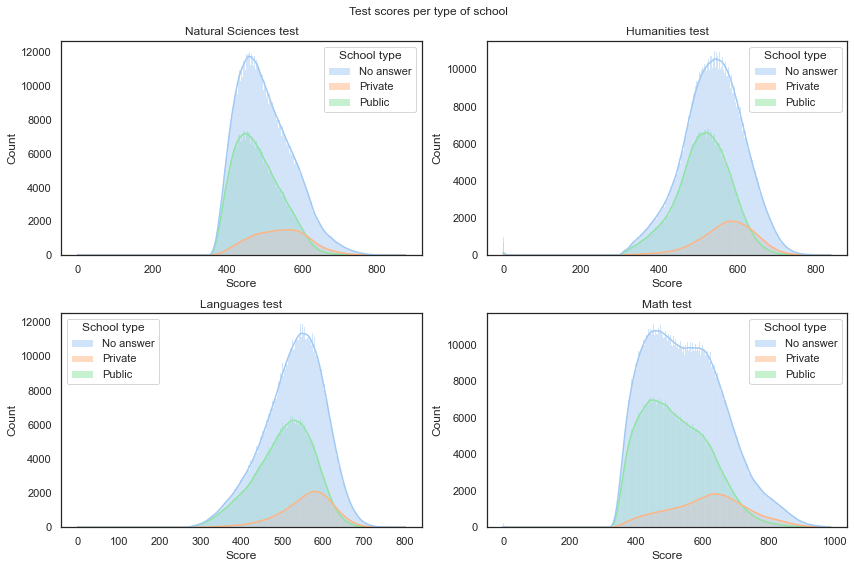

In [41]:
tests = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']
naming_dict = {'NU_NOTA_CN': 'Natural Sciences', 'NU_NOTA_CH': 'Humanities',
              'NU_NOTA_LC': 'Languages', 'NU_NOTA_MT': 'Math'}

fig, ax = plt.subplots(2, 2, figsize = (12,8))
ax = np.reshape(ax, [1,4])


i = 0
for test in tests:
    sns.histplot(data = df,
            x = test,
            kde = True,
            hue = 'School type',
            ax = ax[0][i])
    
    title = f"{naming_dict[test]} test"
    ax[0][i].set_title(title)
    ax[0][i].set_xlabel("Score")
    i += 1
    
    
plt.suptitle('Test scores per type of school')
plt.tight_layout();

We see that, in spite of the vast majority of entries having no answer provided by the students upon their registration for taking the test, there is an overall tendency for private schools' students scoring higher.

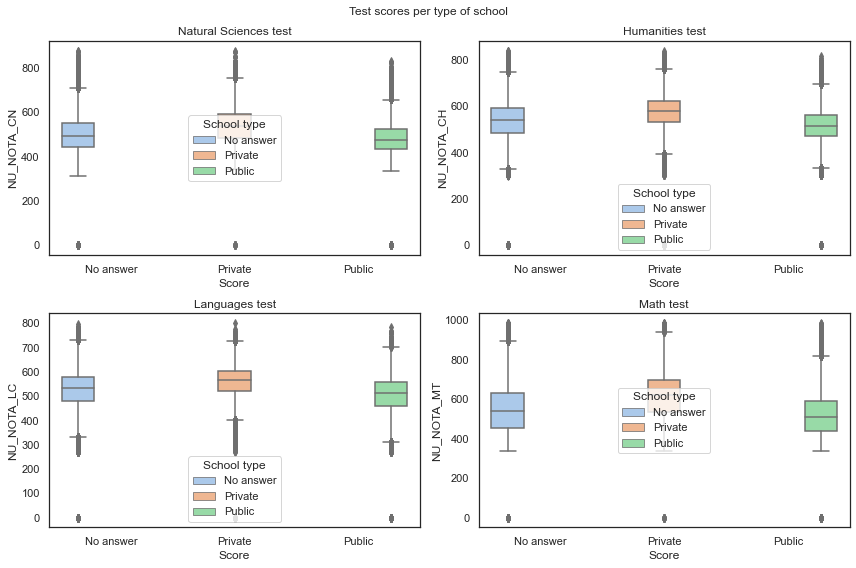

In [46]:
# Same type of information, but as boxplots

fig, ax = plt.subplots(2, 2, figsize = (12,8))
ax = np.reshape(ax, [1,4])


i = 0
for test in tests:
    sns.boxplot(data = df,
            y = test,
            x = 'School type',
            hue = 'School type',
            ax = ax[0][i])
    
    title = f"{naming_dict[test]} test"
    ax[0][i].set_title(title)
    ax[0][i].set_xlabel("Score")
    i += 1
    
    
plt.suptitle('Test scores per type of school')
plt.tight_layout();

### Correlations: ENEM database

Before diving into a correlation analysis, we will define a new column that is simply the student's average score in ENEM 2022, and load external educational budget indicators from SIOPE.

To make it easier to understad what is in each column, we will apply our renaming function, defined in "preprocess.py".

In [20]:
df = rename_columns(df)

In [22]:
df.columns

Index(['High school conclusion year', 'TP_ESCOLA', 'UF', 'SG_UF_PROVA',
       'Natural Sciences score', 'Humanities score', 'Languages score',
       'Math score', 'Age group_1', 'Age group_2',
       ...
       'Q024_A', 'Q024_B', 'Q024_C', 'Q024_D', 'Q024_E', 'Q025_A', 'Q025_B',
       'School type_1.0', 'School type_2.0', 'Average score'],
      dtype='object', length=193)

In [11]:
df.drop(columns = ['SG_UF_PROVA'], inplace = True)

In [22]:
df.head()

,Age group,Gender,Marital state,Ethinicity,Nacionality,High school conclusion year,TP_ESCOLA,School type,UF,SG_UF_PROVA,...,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Average score
40,5,F,1,3,1,0,2,1.0,CE,CE,...,A,A,B,A,A,C,A,A,B,449.925
55,3,F,1,1,1,0,2,1.0,SP,SP,...,A,A,B,A,A,E,A,B,B,766.925
57,2,M,1,3,1,0,2,1.0,GO,GO,...,A,A,C,A,A,E,A,C,B,539.050
59,3,F,1,3,1,0,2,2.0,PA,PA,...,A,A,C,A,A,A,A,A,B,457.450
67,3,M,1,1,1,0,2,1.0,RJ,RJ,...,A,A,C,B,A,D,B,A,B,477.075


In [88]:
df2 = pd.get_dummies(df, columns = ['Age group', 'Gender', 'Marital state', 'Ethinicity', 'Nacionality',
                                   'Q001', 'Q002', 'Q003', 'Q004',
                                   'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013',
                                   'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022',
                                   'Q023', 'Q024', 'Q025', 'School type'])

In [24]:
# Student average score in ENEM
df['Average score'] = 0.25*(df['Natural Sciences score'] + 
                              df['Humanities score'] + 
                              df['Languages score'] + 
                              df['Math score'])

<ipython-input-24-c65ad4a0285a>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr(method = 'spearman')


In [33]:
df.drop(columns = 'TP_ESCOLA', inplace = True)

In [59]:
corr_df = df2.corr(method = 'spearman')

<ipython-input-59-4660ef6a9a77>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df2.corr(method = 'spearman')


KeyboardInterrupt: 

In [ ]:
abs(corr_df['Average score']).sort_values(ascending = False)[0:40]

In [41]:
abs(corr_df['Average score']).sort_values(ascending = False)[0:40]

Average score             1.000000
Humanities score          0.872722
Math score                0.864417
Languages score           0.848827
Natural Sciences score    0.773551
School type_Private       0.393106
School type_Public        0.393106
Q024_A                    0.392878
Q018_B                    0.318025
Q018_A                    0.318025
Q010_A                    0.316824
Q008_B                    0.315128
Q006_B                    0.314552
Ethinicity_1              0.280829
Q016_A                    0.280301
Q013_A                    0.274363
Q014_A                    0.271985
Q016_B                    0.269654
Q003_E                    0.259102
Q014_B                    0.258889
Q019_B                    0.257777
Q001_G                    0.237446
Q002_G                    0.234679
Q007_A                    0.230961
Q003_D                    0.223616
Q004_D                    0.223457
Q003_A                    0.222055
Q004_A                    0.221353
Q004_E              

Correlation with 'Average score' plot

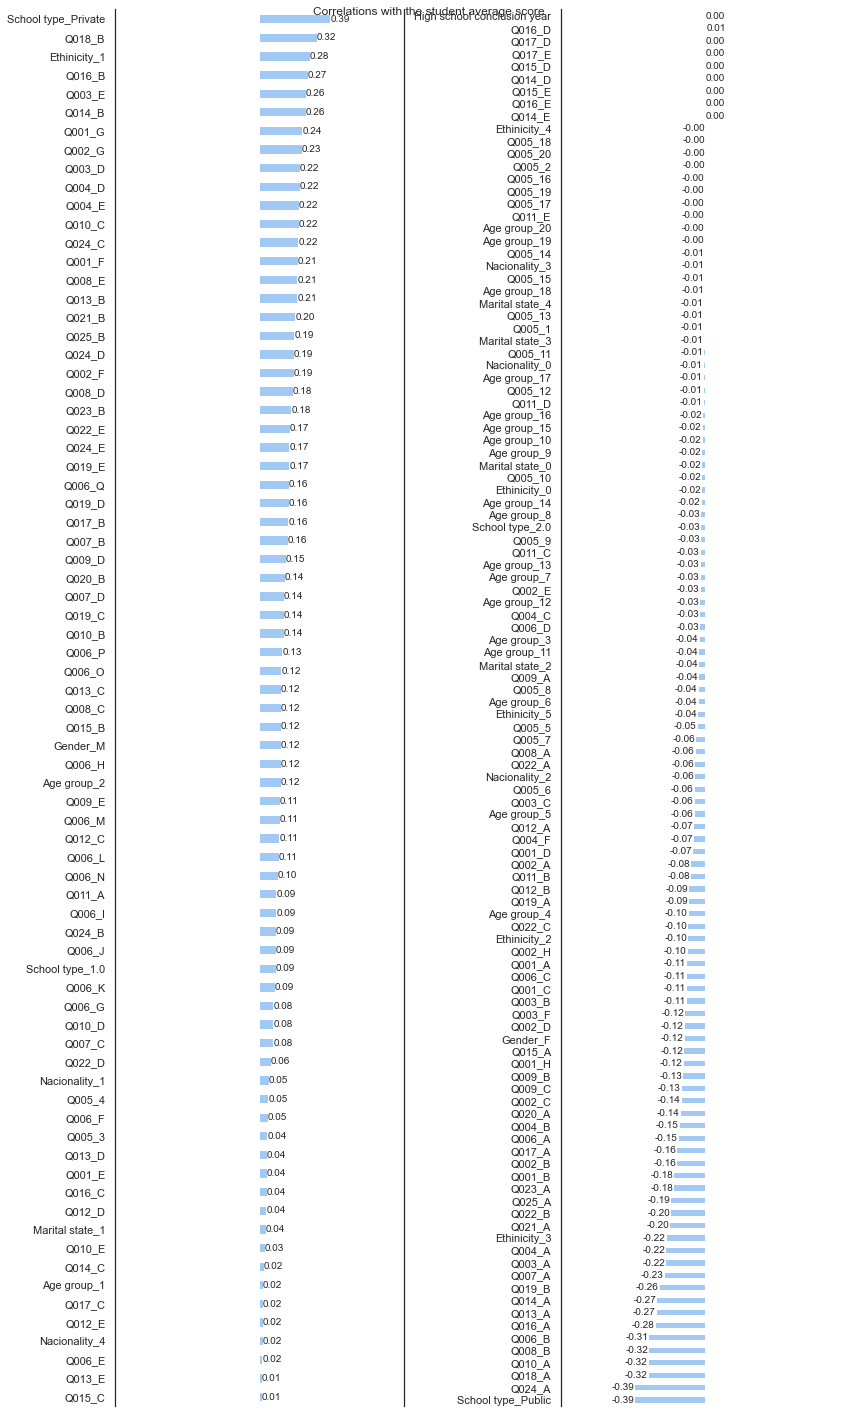

In [44]:
fig, ax = plt.subplots(1,2,figsize = (18,22))

values_to_plot = corr_df['Average score'].sort_values(ascending = False)

# gráfico da esquerda
values_to_plot[5:80].sort_values(ascending = True).plot(kind = 'barh', figsize = (12,20), ax = ax[0])
ax[0].spines['top'].set_visible(False)
#ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].xaxis.set_visible(False)
ax[0].bar_label(ax[0].containers[0], fmt = '%.2f')
ax[0].set_xlim([-0.8, 0.8])

# gráfico da direita
values_to_plot[80:194].sort_values(ascending = True).plot(kind = 'barh', figsize = (12,20), ax = ax[1])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].xaxis.set_visible(False)
ax[1].bar_label(ax[1].containers[0], fmt = '%.2f')
ax[1].set_xlim([-0.8, 0.8])

plt.suptitle('Correlations with the student average score')
plt.tight_layout()

## Preliminary studies with regressors

### AdaBoost

In [45]:
# Libs importing
from sklearn import metrics
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns = ['Average score', 'Natural Sciences score', 'Humanities score', 'Math score', 'Languages score']),
    df['Average score'],
    test_size = 0.3,
    random_state = 1
)

#### A first approach: no feature selection

First approach without any type of feature selection or feature standardization.

In [59]:
df.drop(columns = ['SG_UF_PROVA'], inplace = True)
df = pd.get_dummies(df, columns = ['UF'])

In [76]:
AdaBoost = AdaBoostRegressor()
AdaBoost.fit(X_train, y_train)

AdaBoostRegressor()

In [47]:
AdaBoost = AdaBoostRegressor()
AdaBoost.fit(X_train[abs(corr_df['Average score']).sort_values(ascending = False)[5:30].index], y_train)

AdaBoostRegressor()

In [78]:
y_pred = AdaBoost.predict(X_test)
y_train_pred = AdaBoost.predict(X_train)

In [79]:
print(metrics.r2_score(y_train, y_train_pred))

0.28930049660506674


In [80]:
print(metrics.r2_score(y_test, y_pred))
print(metrics.mean_squared_log_error(y_test, y_pred))
print(metrics.mean_absolute_percentage_error(y_test, y_pred))


0.28917466631966127
0.01304204045340268
0.09274865976337704


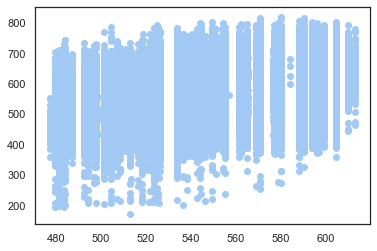

In [81]:
plt.scatter(y_train_pred, y_train, )

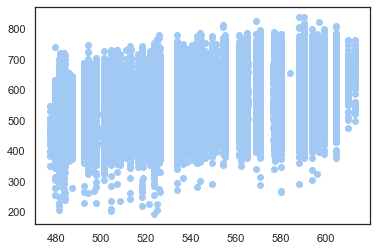

In [82]:
plt.scatter(y_pred, y_test)

Overall, our regression was not optimal in this case: we got a relatively low r2-score (of about 0.29), as well as poor performances for other regression metrics. Moreover, qualitative analysis from the scatter plots clearly show that our predictions are restricted to ranges much narrower than the original values, demonstrating poor prediction power for this model.

Therefore, either this type of problem is ill-posed when attempting to solve with AdaBoost Regressors, or we need to fine-tune the model and better select which features to use (or, maybe, a combination of both).

#### Feature selection based on correlation scores

In [110]:
def train_ada_boost_model(df, test_size, random_state, features, target):
    X_train, X_test, y_train, y_test = train_test_split(df[features], target, test_size = test_size, random_state = random_state)

    ABRegressor = AdaBoostRegressor()
    ABRegressor.fit(X_train, y_train)

    return ABRegressor, X_train, X_test, y_train, y_test

def evaluate_regressor(regressor, X_train, X_test, y_train, y_test):
    regression_metrics = {}
    
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)

    regression_metrics['r2_train'] = metrics.r2_score(y_train, y_train_pred)
    regression_metrics['r2_test'] = metrics.r2_score(y_test, y_test_pred)
    regression_metrics['MAE_train'] = metrics.mean_absolute_error(y_train, y_train_pred)
    regression_metrics['MAE_test'] = metrics.mean_absolute_error(y_test, y_test_pred)
    regression_metrics['MSLE_train'] = metrics.mean_squared_log_error(y_train, y_train_pred)
    regression_metrics['MSLE_test'] = metrics.mean_squared_log_error(y_test, y_test_pred)

    return regression_metrics

In [117]:
def train_with_correlation_feature_selection(X, target, absolute_correlations, n_iter, regressor_type, test_size, random_state):
    total_features = len(absolute_correlations)
    step = int(total_features/n_iter)

    df_result = pd.DataFrame()
    print(f"Will run for {n_iter} steps, adding {step} features per iteration!")

    for i in range(0, n_iter):
        print(f"Now running step {i+1}")
        
        features = absolute_correlations.index[0:(i + 1)*step]
        print(f"Will train model with {len(features)} features.")

        if regressor_type == 'AdaBoost':
            regressor, X_train, X_test, y_train, y_test = train_ada_boost_model(X, test_size, random_state, features, target)

        regression_metrics = evaluate_regressor(regressor, X_train, X_test, y_train, y_test)
        regression_metrics['nFeatures'] = len(features)

        df_result = pd.concat([df_result, pd.DataFrame(regression_metrics, index = [0])], axis = 0)
    
    return df_result

In [125]:
X = df.drop(columns = ['Average score', 'Natural Sciences score', 'Humanities score', 'Math score', 'Languages score'])

df_result = train_with_correlation_feature_selection(
    X,
    df['Average score'],
    abs(corr_df['Average score']).sort_values(ascending = False)[5:-1],
    31,
    'AdaBoost',
    0.3,
    1
    )



Will run for 31 steps, adding 6 features per iteration!
Now running step 1
Now running step 2
Now running step 3
Now running step 4
Now running step 5
Now running step 6
Now running step 7
Now running step 8
Now running step 9
Now running step 10
Now running step 11
Now running step 12
Now running step 13
Now running step 14
Now running step 15
Now running step 16
Now running step 17
Now running step 18
Now running step 19
Now running step 20
Now running step 21
Now running step 22
Now running step 23
Now running step 24
Now running step 25
Now running step 26
Now running step 27
Now running step 28
Now running step 29
Now running step 30
Now running step 31


In [134]:
df_result.head()

,r2_train,r2_test,MAE_train,MAE_test,MSLE_train,MSLE_test,nFeatures
0,0.248778,0.250018,49.997502,49.809847,0.014011,0.013856,6
0,0.271546,0.271872,49.122410,48.936269,0.013527,0.013392,12
0,0.273782,0.273680,49.038839,48.864265,0.013465,0.013339,18
0,0.282198,0.282116,48.773033,48.617585,0.013339,0.013214,24
0,0.282875,0.283028,48.739449,48.563417,0.013312,0.013182,30


<AxesSubplot: >

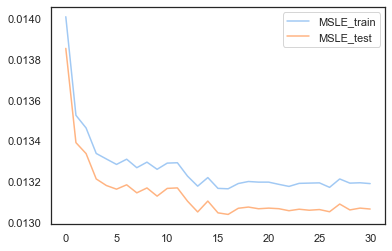

In [137]:
df_result[['MSLE_train', 'MSLE_test']].reset_index(drop=True).plot()

<AxesSubplot: >

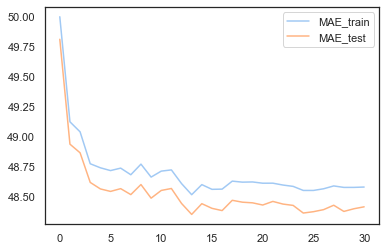

In [135]:
df_result[['MAE_train', 'MAE_test']].reset_index(drop=True).plot()

<AxesSubplot: >

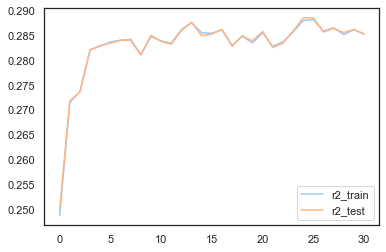

In [126]:
df_result[['r2_train', 'r2_test']].reset_index(drop = True).plot()

### Decision Tree

Let us begin by disregarding any type of hyerarchical relations in our dataset (and features standardization).

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor

In [55]:
X, y = df.drop(columns = ['Average score', 'Natural Sciences score', 'Humanities score', 'Math score', 'Languages score']), df['Average score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4) 

In [56]:
dt_regressor = DecisionTreeRegressor(random_state = 0)
dt_regressor.fit(X_train, y_train)

ValueError: could not convert string to float: 'SC'

In [27]:
y_pred_train = dt_regressor.predict(X_train)
print(r2_score(y_train, y_pred_train),
mean_absolute_error(y_train, y_pred_train))

0.999803739201809 0.028307287583826987


In [32]:
y_pred = dt_regressor.predict(X_test)
print(r2_score(y_test, y_pred),
mean_absolute_error(y_test, y_pred))

0.05993937713714115 54.009454816904665


Text(0.5, 0.98, 'Comparação de predições e valores reais')

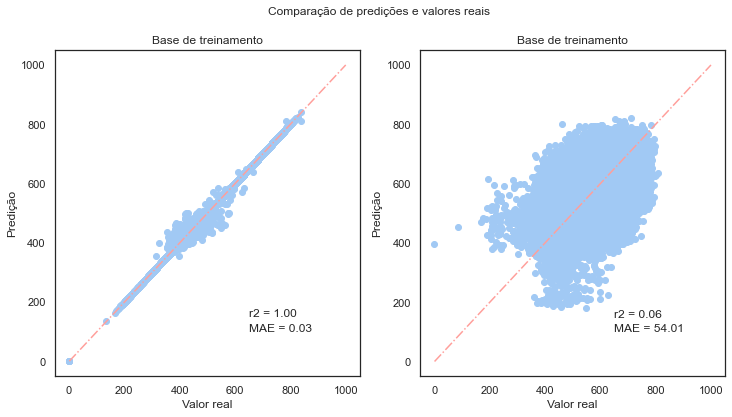

In [57]:
fig, ax = plt.subplots(1,2,figsize = (12,6))
plt.title('Comparação de predições e valores reais')

r2_train = np.round(r2_score(y_train, y_pred_train),6)
MAE_train = mean_absolute_error(y_train, y_pred_train)

ax[0].scatter(y_train,y_pred_train)
ax[0].set_title('Base de treinamento')
ax[0].text(650, 150, f"r2 = {r2_train:.2f}", fontsize = 12)
ax[0].text(650, 100, f"MAE = {MAE_train:.2f}", fontsize = 12)
ax[0].plot(np.linspace(1,1000), np.linspace(1,1000), '-.r')
ax[0].set_xlabel('Valor real')
ax[0].set_ylabel('Predição')

r2_test = np.round(r2_score(y_test, y_pred),6)
MAE_test = mean_absolute_error(y_test, y_pred)

ax[1].scatter(y_test,y_pred)
ax[1].set_title('Base de treinamento')
ax[1].text(650, 150, f"r2 = {r2_test:.2f}", fontsize = 12)
ax[1].text(650, 100, f"MAE = {MAE_test:.2f}", fontsize = 12)
ax[1].plot(np.linspace(1,1000), np.linspace(1,1000), '-.r')
ax[1].set_xlabel('Valor real')
ax[1].set_ylabel('Predição')

plt.suptitle('Comparação de predições e valores reais')

We can see a good performance on the training set, which does not hold for the test dataset. This indicates that the decision tree model probably overfitted the data. In fact, r2-score for the test set was considerably worse than for the training data, as was the MAE, which was 1800 times higher!

#### With feature selection

As previously, we will work with a simple filter for feature selection based on correlations.

In [50]:
dt_regressor = DecisionTreeRegressor(random_state = 0)

In [62]:
R = corr_df['Pontuação média'].sort_values(ascending = False)
R[0:8]

Pontuação média                          1.000000
NU_NOTA_REDACAO                          0.627857
NU_NOTA_COMP3                            0.573466
NU_NOTA_COMP1                            0.568791
NU_NOTA_COMP5                            0.555989
NU_NOTA_COMP4                            0.546879
NU_NOTA_COMP2                            0.536783
Tipo de Instituição de Ensino_Privada    0.381859
Name: Pontuação média, dtype: float64

In [65]:
R.drop(['Pontuação média', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'], inplace = True)

In [66]:
R.shape

(185,)

In [69]:
R = abs(R).sort_values(ascending = False)
R

Q024_A                                   0.389073
Tipo de Instituição de Ensino_Pública    0.381859
Tipo de Instituição de Ensino_Privada    0.381859
Q018_B                                   0.315778
Q018_A                                   0.315778
                                           ...   
Faixa etária_20                          0.002170
Q015_E                                   0.001964
Q016_E                                   0.001762
Q014_E                                   0.000883
Ano conclusão EM                              NaN
Name: Pontuação média, Length: 185, dtype: float64

In [75]:
X, y = df2.drop(['Pontuação média', 'target', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'], axis = 1), df2['Pontuação média']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4) 

df_train = pd.DataFrame()
df_test = pd.DataFrame()

results_corr = {'r2': [],
               'MAE': [],
               'scenario': [],
               'method': []}

step = 5
n = int(R.shape[0]/step)
count = 0

#for feature in F2.index:
for i in range(0,n):
    
    feature = list(R.index[i*5: 5 + i*5])
    print(f"Now adding feature {feature}...")
    print(f"Iteration: {count + 1}")
    
    df_train = pd.concat([df_train, X_train[feature]], axis = 1)
    df_test = pd.concat([df_test, X_test[feature]], axis = 1)

    dt_regressor.fit(df_train, y_train)
    
    y_pred_train = dt_regressor.predict(df_train)
    r2 = r2_score(y_train, y_pred_train)
    results_corr['r2'].append(r2)
    results_corr['MAE'].append(mean_absolute_error(y_train, y_pred_train))
    results_corr['scenario'].append('train')
    results_corr['method'].append('Correlação')
    
    y_pred_test = dt_regressor.predict(df_test)
    r2 = r2_score(y_test, y_pred_test)
    results_corr['r2'].append(r2)
    results_corr['MAE'].append(mean_absolute_error(y_test, y_pred_test))
    results_corr['scenario'].append('test')
    results_corr['method'].append('Correlação')
    
    count += 1

Now adding feature ['Q024_A', 'Tipo de Instituição de Ensino_Pública', 'Tipo de Instituição de Ensino_Privada', 'Q018_B', 'Q018_A']...
Iteration: 1
Now adding feature ['Q010_A', 'Q006_B', 'Q008_B', 'Q016_A', 'Cor/Raça_1']...
Iteration: 2
Now adding feature ['Q014_A', 'Q013_A', 'Q016_B', 'Q014_B', 'Q019_B']...
Iteration: 3
Now adding feature ['Q003_E', 'Q003_D', 'Q004_D', 'Q002_G', 'Q003_A']...
Iteration: 4
Now adding feature ['Q004_A', 'Q001_G', 'Q013_B', 'Q024_C', 'Q010_C']...
Iteration: 5
Now adding feature ['Q001_F', 'Cor/Raça_3', 'Q004_E', 'Q022_B', 'Q007_A']...
Iteration: 6
Now adding feature ['Q025_A', 'Q025_B', 'Q008_E', 'Q021_A', 'Q021_B']...
Iteration: 7
Now adding feature ['Q002_F', 'Q024_D', 'Q008_D', 'Q023_A', 'Q023_B']...
Iteration: 8
Now adding feature ['Q001_B', 'Q006_A', 'Q022_E', 'Q019_D', 'Q002_B']...
Iteration: 9
Now adding feature ['Q019_E', 'Q010_B', 'Q024_E', 'Q006_Q', 'Q019_C']...
Iteration: 10
Now adding feature ['Q017_A', 'Q017_B', 'Q007_B', 'Q009_D', 'Q008_C']

In [78]:
pd.DataFrame(results_corr)

,r2,MAE,scenario,method
0,0.247612,48.935913,train,Correlação
1,0.250359,48.928833,test,Correlação
2,0.280183,47.738639,train,Correlação
3,0.282086,47.740249,test,Correlação
4,0.291285,47.311853,train,Correlação
...,...,...,...,...
69,-0.343346,64.662848,test,Correlação
70,0.989478,1.016250,train,Correlação
71,-0.342906,64.700338,test,Correlação
72,0.989478,1.016250,train,Correlação


Let us begin to plot regression metrics as we add features to the model.

<AxesSubplot: >

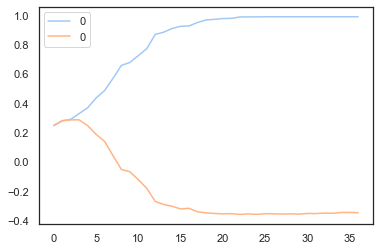

In [76]:
ax = pd.DataFrame(r2_train, index = [0]).transpose().plot()
pd.DataFrame(r2_test, index = [0]).transpose().plot(ax = ax)

In [79]:
X, y = df4.drop(['Pontuação média', 'target', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'], axis = 1), df4['Pontuação média']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4) 

df_train = pd.DataFrame()
df_test = pd.DataFrame()

results_F = {'r2': [],
               'MAE': [],
               'scenario': [],
               'method': []}

F2 = F.drop(['NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Pontuação média']).sort_values(ascending = False)

step = 5
n = int(F2.shape[0]/step)
count = 0

#for feature in F2.index:
for i in range(0,n):
    
    feature = list(F2.index[i*5: 5 + i*5])
    print(f"Now adding feature {feature}...")
    print(f"Iteration: {count + 1}")
    
    df_train = pd.concat([df_train, X_train[feature]], axis = 1)
    df_test = pd.concat([df_test, X_test[feature]], axis = 1)

    dt_regressor.fit(df_train, y_train)
    
    y_pred_train = dt_regressor.predict(df_train)
    r2 = r2_score(y_train, y_pred_train)
    results_F['r2'].append(r2)
    results_F['MAE'].append(mean_absolute_error(y_train, y_pred_train))
    results_F['scenario'].append('train')
    results_F['method'].append('Fisher')
    
    y_pred_test = dt_regressor.predict(df_test)
    r2 = r2_score(y_test, y_pred_test)
    results_F['r2'].append(r2)
    results_F['MAE'].append(mean_absolute_error(y_test, y_pred_test))
    results_F['scenario'].append('test')
    results_F['method'].append('Fisher')
    
    count += 1

Now adding feature ['Q024_A', 'Tipo de Instituição de Ensino_Pública', 'Tipo de Instituição de Ensino_Privada', 'Q010_A', 'Q006_B']...
Iteration: 1
Now adding feature ['Q018_A', 'Q018_B', 'Q008_B', 'Cor/Raça_1', 'Q016_A']...
Iteration: 2
Now adding feature ['Q014_A', 'Q013_A', 'Q016_B', 'Q014_B', 'Q003_D']...
Iteration: 3
Now adding feature ['Q019_B', 'Q004_D', 'Q003_E', 'Q013_B', 'Q003_A']...
Iteration: 4
Now adding feature ['Q004_A', 'Q002_G', 'Q024_C', 'Q001_F', 'Q001_G']...
Iteration: 5
Now adding feature ['Cor/Raça_3', 'Q010_C', 'Q022_B', 'Q025_B', 'Q025_A']...
Iteration: 6
Now adding feature ['Q002_F', 'Q004_E', 'Q021_A', 'Q021_B', 'Q008_E']...
Iteration: 7
Now adding feature ['Q007_A', 'Q008_D', 'Q001_B', 'Q024_D', 'Q023_A']...
Iteration: 8
Now adding feature ['Q023_B', 'Q006_A', 'Q022_E', 'Q010_B', 'Q002_B']...
Iteration: 9
Now adding feature ['Q019_D', 'Q019_C', 'Q019_E', 'Q024_B', 'Q008_C']...
Iteration: 10
Now adding feature ['Q024_E', 'Q009_D', 'Q006_H', 'Q017_A', 'Q017_B']

##### Plots

In [82]:
corr_df = pd.DataFrame(results_corr)
F_df = pd.DataFrame(results_F)
F_df.loc[:,'method'] = 'Fisher'

results_df = pd.concat([
    corr_df,
    F_df
], axis = 0)

In [83]:
results_df

,r2,MAE,scenario,method
0,0.247612,48.935913,train,Correlação
1,0.250359,48.928833,test,Correlação
2,0.280183,47.738639,train,Correlação
3,0.282086,47.740249,test,Correlação
4,0.291285,47.311853,train,Correlação
...,...,...,...,...
69,-0.348437,64.814951,test,Fisher
70,0.989478,1.016250,train,Fisher
71,-0.347261,64.803844,test,Fisher
72,0.989478,1.016250,train,Fisher


Text(0, 0.5, 'R2')

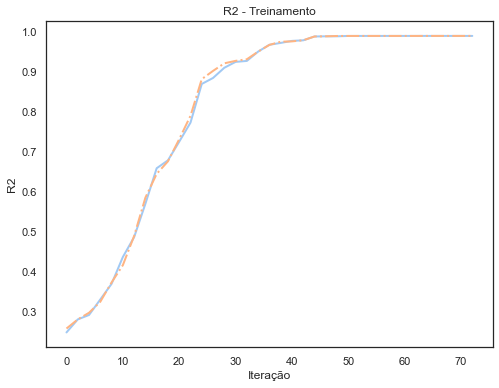

In [101]:
ax = corr_df[corr_df['scenario'] == 'train']['r2'].plot(linewidth = 2)
F_df[corr_df['scenario'] == 'train']['r2'].plot(ax = ax, linestyle = '-.', figsize = (8,6), linewidth = 2)
plt.title('R2 - Treinamento')
ax.set_xlabel('Iteração')
ax.set_ylabel('R2')

Text(0, 0.5, 'MAE')

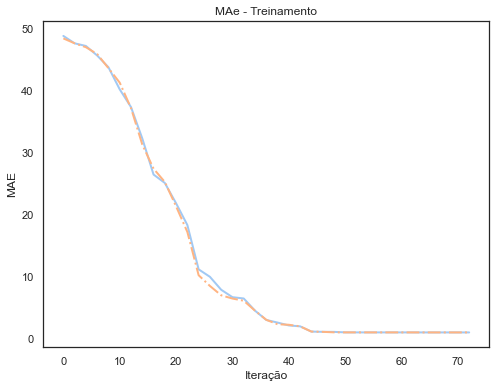

In [103]:
ax = corr_df[corr_df['scenario'] == 'train']['MAE'].plot(linewidth = 2)
F_df[corr_df['scenario'] == 'train']['MAE'].plot(ax = ax, linestyle = '-.', figsize = (8,6), linewidth = 2)
plt.title('MAe - Treinamento')
ax.set_xlabel('Iteração')
ax.set_ylabel('MAE')

In [124]:
corr_df

,r2,MAE,scenario,method
0,0.247612,48.935913,train,Correlação
1,0.250359,48.928833,test,Correlação
2,0.280183,47.738639,train,Correlação
3,0.282086,47.740249,test,Correlação
4,0.291285,47.311853,train,Correlação
...,...,...,...,...
69,-0.343346,64.662848,test,Correlação
70,0.989478,1.016250,train,Correlação
71,-0.342906,64.700338,test,Correlação
72,0.989478,1.016250,train,Correlação


In [133]:
np.arange(1,38,0.5)

array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5,
       12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. ,
       17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5,
       23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5, 28. ,
       28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. , 33.5,
       34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5])

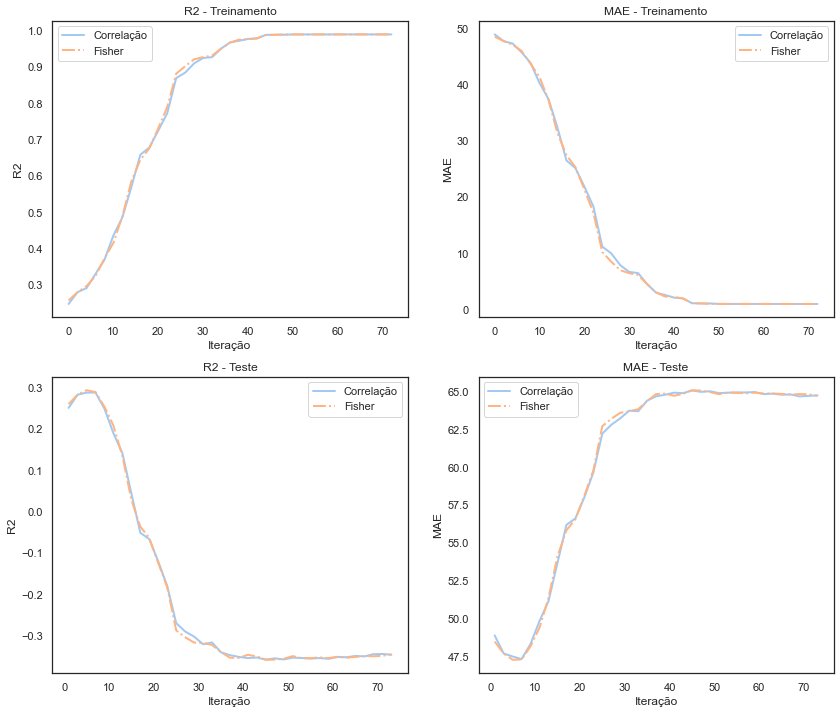

In [135]:
fig, ax = plt.subplots(2,2,figsize = (14,12))

ax = np.reshape(ax, [1,4])

corr_df[corr_df['scenario'] == 'train']['r2'].plot(ax = ax[0][0], linewidth = 2)
F_df[corr_df['scenario'] == 'train']['r2'].plot(ax = ax[0][0], linestyle = '-.', linewidth = 2)
ax[0][0].set_title('R2 - Treinamento')
ax[0][0].set_xlabel('Iteração')
ax[0][0].set_ylabel('R2')
ax[0][0].legend(['Correlação', 'Fisher'])

corr_df[corr_df['scenario'] == 'train']['MAE'].plot(ax = ax[0][1], linewidth = 2)
F_df[corr_df['scenario'] == 'train']['MAE'].plot(ax = ax[0][1], linestyle = '-.', linewidth = 2)
ax[0][1].set_title('MAE - Treinamento')
ax[0][1].set_xlabel('Iteração')
ax[0][1].set_ylabel('MAE')
ax[0][1].legend(['Correlação', 'Fisher'])

corr_df[corr_df['scenario'] == 'test']['r2'].plot(ax = ax[0][2], linewidth = 2)
F_df[corr_df['scenario'] == 'test']['r2'].plot(ax = ax[0][2], linestyle = '-.', linewidth = 2)
ax[0][2].set_title('R2 - Teste')
ax[0][2].set_xlabel('Iteração')
ax[0][2].set_ylabel('R2')
ax[0][2].legend(['Correlação', 'Fisher'])

corr_df[corr_df['scenario'] == 'test']['MAE'].plot(ax = ax[0][3], linewidth = 2)
F_df[corr_df['scenario'] == 'test']['MAE'].plot(ax = ax[0][3], linestyle = '-.', linewidth = 2)
ax[0][3].set_title('MAE - Teste')
ax[0][3].set_xlabel('Iteração')
ax[0][3].set_ylabel('MAE')
ax[0][3].legend(['Correlação', 'Fisher'])



In [122]:
[str(x) for x in np.linspace(1,37,37)]

['1.0',
 '2.0',
 '3.0',
 '4.0',
 '5.0',
 '6.0',
 '7.0',
 '8.0',
 '9.0',
 '10.0',
 '11.0',
 '12.0',
 '13.0',
 '14.0',
 '15.0',
 '16.0',
 '17.0',
 '18.0',
 '19.0',
 '20.0',
 '21.0',
 '22.0',
 '23.0',
 '24.0',
 '25.0',
 '26.0',
 '27.0',
 '28.0',
 '29.0',
 '30.0',
 '31.0',
 '32.0',
 '33.0',
 '34.0',
 '35.0',
 '36.0',
 '37.0']

In [92]:
X, y = df4.drop(['Pontuação média', 'target', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'], axis = 1), df4['Pontuação média']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4) 

df_train = pd.DataFrame()
df_test = pd.DataFrame()

r2_train = {}
r2_test = {}

F2 = F.drop(['NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Pontuação média']).sort_values(ascending = False)

step = 5
n = int(F2.shape[0]/step)
count = 0

#for feature in F2.index:
for i in range(0,n):
    
    feature = list(F2.index[i*5: 5 + i*5])
    print(f"Now adding feature {feature}...")
    print(f"Iteration: {count + 1}")
    
    df_train = pd.concat([df_train, X_train[feature]], axis = 1)
    df_test = pd.concat([df_test, X_test[feature]], axis = 1)

    dt_regressor.fit(df_train, y_train)
    
    y_pred_train = dt_regressor.predict(df_train)
    r2 = r2_score(y_train, y_pred_train)
    r2_train[i] = r2
    
    y_pred_test = dt_regressor.predict(df_test)
    r2 = r2_score(y_test, y_pred_test)
    r2_test[i] = r2
    
    count += 1

Now adding feature ['Q024_A', 'Tipo de Instituição de Ensino_Pública', 'Tipo de Instituição de Ensino_Privada', 'Q010_A', 'Q006_B']...
Iteration: 1
Now adding feature ['Q018_A', 'Q018_B', 'Q008_B', 'Cor/Raça_1', 'Q016_A']...
Iteration: 2
Now adding feature ['Q014_A', 'Q013_A', 'Q016_B', 'Q014_B', 'Q003_D']...
Iteration: 3
Now adding feature ['Q019_B', 'Q004_D', 'Q003_E', 'Q013_B', 'Q003_A']...
Iteration: 4
Now adding feature ['Q004_A', 'Q002_G', 'Q024_C', 'Q001_F', 'Q001_G']...
Iteration: 5
Now adding feature ['Cor/Raça_3', 'Q010_C', 'Q022_B', 'Q025_B', 'Q025_A']...
Iteration: 6
Now adding feature ['Q002_F', 'Q004_E', 'Q021_A', 'Q021_B', 'Q008_E']...
Iteration: 7
Now adding feature ['Q007_A', 'Q008_D', 'Q001_B', 'Q024_D', 'Q023_A']...
Iteration: 8
Now adding feature ['Q023_B', 'Q006_A', 'Q022_E', 'Q010_B', 'Q002_B']...
Iteration: 9
Now adding feature ['Q019_D', 'Q019_C', 'Q019_E', 'Q024_B', 'Q008_C']...
Iteration: 10
Now adding feature ['Q024_E', 'Q009_D', 'Q006_H', 'Q017_A', 'Q017_B']

<AxesSubplot: >

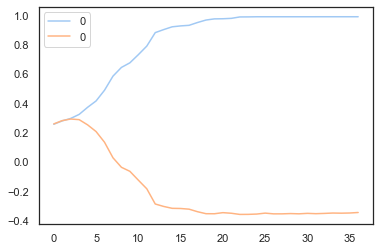

In [101]:
ax = pd.DataFrame(r2_train, index = [0]).transpose().plot()
pd.DataFrame(r2_test, index = [0]).transpose().plot(ax = ax)

<AxesSubplot: >

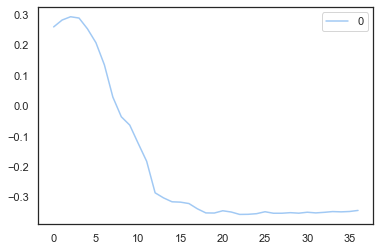

In [98]:
pd.DataFrame(r2_test, index = [0]).transpose().plot()

In [114]:
feature = list(F2.index[0: 5 + 2*5])
df_train = X_train[feature]
df_test = X_test[feature]

dt_regressor.fit(df_train, y_train)

DecisionTreeRegressor(random_state=0)

In [115]:
y_pred_train = dt_regressor.predict(df_train)
r2_score(y_train, y_pred_train)

0.29685336760014147

In [116]:
y_pred_test = dt_regressor.predict(df_test)
r2_score(y_test, y_pred_test)

0.2928883131425981

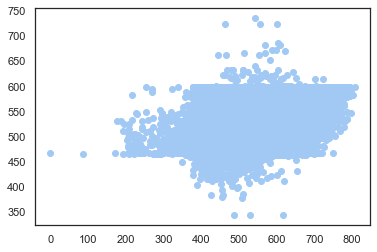

In [117]:
plt.scatter(y_test,y_pred_test)

#### Gradient boosting

In [6]:
df = joblib.load("2022_processed_df.pkl")

In [8]:
features = R[6:40].index.to_list()

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold

model = GradientBoostingRegressor()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'Average score')[features], df['Average score'], test_size = 0.3, random_state = 1)

In [175]:
X_train.shape

(461476, 32)

In [176]:
X_test.shape

(197776, 32)

In [177]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

In [73]:
# gradient boosting for regression in scikit-learn

# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# evaluate the model


# fit the model on the whole dataset
model = GradientBoostingRegressor()
model.fit(X, y)
# make a single prediction
row = [[2.02220122, 0.31563495, 0.82797464, -0.30620401, 0.16003707, -1.44411381, 0.87616892, -0.50446586, 0.23009474, 0.76201118]]
yhat = model.predict(row)
print('Prediction: %.3f' % yhat[0])

{'Q024_A': 0.15150396479674189,
 'Tipo de Instituição de Ensino_Pública': 0.23579937699309672,
 'Tipo de Instituição de Ensino_Privada': 0.2357993769930966,
 'Q010_A': 0.2479601409203025,
 'Q006_B': 0.2595219249237638,
 'Q018_A': 0.26647459302025367,
 'Q018_B': 0.26647459302025367,
 'Q008_B': 0.27074486912951357,
 'Cor/Raça_1': 0.2808472884179155,
 'Q016_A': 0.28208571731749854,
 'Q014_A': 0.2823897981379859}

In [55]:
F.index[0]

'Ano conclusão EM'

In [12]:
param_grid = {
    'max_depth': [90, 100],
    'max_features': ["sqrt", "log2"],
    'min_samples_leaf': [1, 3],
    'min_samples_split': [2, 3],
    'criterion': ["squared_error", "friedman_mse"],
    'splitter': ["best", "random"]
}

rf = DecisionTreeRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose =2, scoring='r2',  n_jobs = -1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': [90, 100],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 3],
                         'splitter': ['best', 'random']},
             scoring='r2', verbose=2)

In [13]:
grid_search.best_params_

{'criterion': 'squared_error',
 'max_depth': 100,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'splitter': 'random'}

In [15]:
y_pred = best_grid.predict(X_train)
r2_score(y_train, y_pred)

NameError: name 'best_grid' is not defined

In [16]:
grid_search

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': [90, 100],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 3],
                         'splitter': ['best', 'random']},
             scoring='r2', verbose=2)

In [14]:
y_pred = grid_search.predict(X_train)

In [15]:
r2_score(y_train,y_pred)

0.36249456347386777

In [16]:
y_pred = grid_search.predict(X_test)
r2_score(y_test,y_pred)

0.2718379878806808

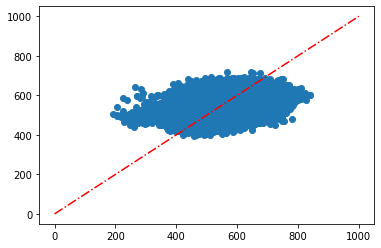

In [17]:
plt.scatter(y_test,y_pred)
x = np.linspace(0,1000,1000)
y = x
plt.plot(x,y, '-.r')

In [18]:
grid_search.estimator.fit(X_train, y_train).feature_importances_

array([0.31684285, 0.13159849, 0.01389634, 0.01247767, 0.02504468,
       0.02262338, 0.01951616, 0.02761777, 0.01703751, 0.02287749,
       0.01200399, 0.02003134, 0.01857407, 0.0167564 , 0.03164272,
       0.0150525 , 0.02329164, 0.02972448, 0.02080864, 0.01876866,
       0.00927066, 0.0124637 , 0.01275485, 0.02550542, 0.01565434,
       0.01744155, 0.01639144, 0.01295604, 0.01553741, 0.01231074,
       0.01353662, 0.01395159, 0.00272105, 0.00331783])

In [21]:
from preprocess import evaluate_regressor

In [22]:
evaluate_regressor(grid_search, X_train, X_test, y_train, y_test)

{'r2_train': 0.36249456347386777,
 'r2_test': 0.2718379878806808,
 'MAE_train': 45.70672912988111,
 'MAE_test': 48.61101577857314,
 'MSLE_train': 0.011900092242508653,
 'MSLE_test': 0.013376825491500044}

## Tentativa com modelagem multinível

In [4]:
df = joblib.load('2022_processed_df.pkl')

In [12]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [15]:
df.head()

,High school conclusion year,Natural Sciences score,Humanities score,Languages score,Math score,Age group_1,Age group_2,Age group_3,Age group_4,Age group_5,...,UF_PR,UF_RJ,UF_RN,UF_RO,UF_RR,UF_RS,UF_SC,UF_SE,UF_SP,UF_TO
40,0,436.7,420.0,512.6,430.4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
55,0,819.5,684.9,657.8,905.5,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
57,0,442.4,579.2,582.7,551.9,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,0,461.4,485.9,448.9,433.6,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,427.8,485.0,557.5,438.0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [13]:
df2 = undummify(df)

In [16]:
df2['UF'].head()

40    CE
55    SP
57    GO
59    PA
67    RJ
Name: UF, dtype: object

In [5]:
df.head()

,High school conclusion year,Natural Sciences score,Humanities score,Languages score,Math score,Age group_1,Age group_2,Age group_3,Age group_4,Age group_5,...,UF_PR,UF_RJ,UF_RN,UF_RO,UF_RR,UF_RS,UF_SC,UF_SE,UF_SP,UF_TO
40,0,436.7,420.0,512.6,430.4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
55,0,819.5,684.9,657.8,905.5,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
57,0,442.4,579.2,582.7,551.9,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,0,461.4,485.9,448.9,433.6,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,427.8,485.0,557.5,438.0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Average score distribution for a few states')

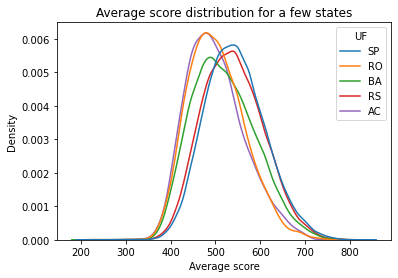

In [18]:
sns.kdeplot(data = df2[df2['UF'].isin(['SP', 'AC', 'RO', 'BA', 'RS'])],
               x = 'Average score',
                hue = 'UF',
           common_norm = False)
plt.title("Average score distribution for a few states")

We see that score distributions can vary largely depending on the state. We can use state information as an additional source of information using mixed models.

In [19]:
import statsmodels.api as sm

c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [20]:
df2.head()

,High school conclusion year,Natural Sciences score,Humanities score,Languages score,Math score,Age group,Gender,Marital state,Ethinicity,Nacionality,...,Q019,Q020,Q021,Q022,Q023,Q024,Q025,School type,Average score,UF
40,0,436.7,420.0,512.6,430.4,5,F,1,3,1,...,B,A,A,C,A,A,B,1.0,449.925,CE
55,0,819.5,684.9,657.8,905.5,3,F,1,1,1,...,B,A,A,E,A,B,B,1.0,766.925,SP
57,0,442.4,579.2,582.7,551.9,2,M,1,3,1,...,C,A,A,E,A,C,B,1.0,539.050,GO
59,0,461.4,485.9,448.9,433.6,3,F,1,3,1,...,C,A,A,A,A,A,B,2.0,457.450,PA
67,0,427.8,485.0,557.5,438.0,3,M,1,1,1,...,C,B,A,D,B,A,B,1.0,477.075,RJ


In [27]:
for i in df2.columns:
    print(i)

High school conclusion year
Natural Sciences score
Humanities score
Languages score
Math score
Age group
Gender
Marital state
Ethinicity
Nacionality
Q001
Q002
Q003
Q004
Q005
Q006
Q007
Q008
Q009
Q010
Q011
Q012
Q013
Q014
Q015
Q016
Q017
Q018
Q019
Q020
Q021
Q022
Q023
Q024
Q025
School type
Average score
UF


In [48]:
features = ["School type"]
df_test = df2[df2['UF'].isin(["SP", "MG", "RS", "AM", "BA"])]
X = pd.get_dummies(df_test[features])
y = df_test["Average score"]

model = sm.MixedLM(endog = y.values, exog = X.values, groups = df_test['UF'])

In [50]:
df_test

,High school conclusion year,Natural Sciences score,Humanities score,Languages score,Math score,Age group,Gender,Marital state,Ethinicity,Nacionality,...,Q019,Q020,Q021,Q022,Q023,Q024,Q025,School type,Average score,UF
55,0,819.5,684.9,657.8,905.5,3,F,1,1,1,...,B,A,A,E,A,B,B,1.0,766.925,SP
92,0,545.1,636.2,623.1,637.9,3,M,1,2,1,...,C,A,A,C,B,B,B,1.0,610.575,SP
103,0,370.0,476.9,458.7,404.3,2,F,1,3,1,...,C,A,A,E,A,B,B,1.0,427.475,SP
142,0,476.4,533.0,431.0,450.2,4,M,1,2,1,...,A,A,A,C,A,A,B,1.0,472.650,BA
154,0,417.0,498.8,568.5,508.2,2,F,1,0,1,...,C,A,A,D,A,B,B,1.0,498.125,MG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476063,0,488.6,513.2,447.6,543.9,2,M,1,1,1,...,C,A,A,D,A,B,B,1.0,498.325,SP
3476070,0,484.6,543.4,544.2,589.0,2,F,1,3,1,...,D,A,B,D,A,B,B,1.0,540.300,SP
3476074,0,378.0,443.1,367.3,449.9,4,M,0,3,1,...,B,A,A,B,A,A,B,1.0,409.575,RS
3476086,0,446.2,557.5,556.2,492.0,2,M,1,1,1,...,C,B,A,D,A,B,B,1.0,512.975,RS


In [65]:
df_test['Natural_Sciences_score']

55         819.5
92         545.1
103        370.0
142        476.4
154        417.0
           ...  
3476063    488.6
3476070    484.6
3476074    378.0
3476086    446.2
3476098    487.6
Name: Natural_Sciences_score, Length: 261338, dtype: float64

In [95]:
df.head()

,High school conclusion year,Natural Sciences score,Humanities score,Languages score,Math score,Age group_1,Age group_2,Age group_3,Age group_4,Age group_5,...,UF_PR,UF_RJ,UF_RN,UF_RO,UF_RR,UF_RS,UF_SC,UF_SE,UF_SP,UF_TO
40,0,436.7,420.0,512.6,430.4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
55,0,819.5,684.9,657.8,905.5,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
57,0,442.4,579.2,582.7,551.9,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,0,461.4,485.9,448.9,433.6,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,427.8,485.0,557.5,438.0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [66]:
import statsmodels.formula.api as smf

In [107]:
#df_test = df_test.rename(columns = {"Average score": "Average_score", "Natural Sciences score": "Natural_Sciences_score"})
model = smf.mixedlm("y ~ x1 + x2 + x3 + x4", data = df.rename(columns = {'School type_Private': 'x1', 'Q018_B': 'x2', 'Q024_A': 'x3', 'Ethinicity_1': 'x4', 'Average score': 'y'}), groups = df2['UF'])

In [108]:
result = model.fit()

In [109]:
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: y            
No. Observations: 659252  Method:             REML         
No. Groups:       27      Scale:              3757.9157    
Min. group size:  1293    Log-Likelihood:     -3648866.5503
Max. group size:  133816  Converged:          Yes          
Mean group size:  24416.7                                  
-----------------------------------------------------------
             Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept   512.207    1.435  357.059 0.000 509.395 515.019
x1           42.840    0.193  222.141 0.000  42.462  43.218
x2           14.758    0.191   77.286 0.000  14.384  15.132
x3          -30.529    0.181 -168.375 0.000 -30.884 -30.173
x4           16.222    0.169   96.057 0.000  15.891  16.553
Group Var    54.670    0.250                               
===========================================================

"""

In [110]:
y_pred = result.predict(df.rename(columns = {'School type_Private': 'x1', 'Q018_B': 'x2', 'Q024_A': 'x3', 'Ethinicity_1': 'x4', 'Average score': 'y'}))

40         500.665466
55         500.665466
57         500.665466
59         500.665466
67         500.665466
              ...    
3476074    500.665466
3476086    524.946018
3476093    500.665466
3476098    500.665466
3476102    524.946018
Length: 659252, dtype: float64

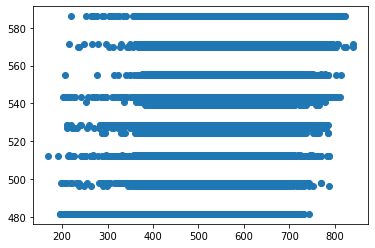

In [111]:
plt.scatter(df['Average score'], y_pred)

In [92]:
from sklearn import metrics

In [94]:
metrics.r2_score(y, y_pred)

0.0029959742765779396

In [37]:
y

55         766.925
92         610.575
103        427.475
142        472.650
154        498.125
            ...   
3476063    498.325
3476070    540.300
3476074    409.575
3476086    512.975
3476098    531.525
Name: Average score, Length: 261338, dtype: float64

In [36]:
y_pred

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

In [112]:
df.head()

,High school conclusion year,Natural Sciences score,Humanities score,Languages score,Math score,Age group_1,Age group_2,Age group_3,Age group_4,Age group_5,...,UF_PR,UF_RJ,UF_RN,UF_RO,UF_RR,UF_RS,UF_SC,UF_SE,UF_SP,UF_TO
40,0,436.7,420.0,512.6,430.4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
55,0,819.5,684.9,657.8,905.5,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
57,0,442.4,579.2,582.7,551.9,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,0,461.4,485.9,448.9,433.6,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
67,0,427.8,485.0,557.5,438.0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
for i in df.columns:
    print(i)

In [165]:
features = R[6:38].index.to_list()
mixed_lm = sm.MixedLM(df['Average score'], df.loc[:, features], groups = df2['UF']).fit()

c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2131: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [121]:
pd.set_option("display.max_columns", None)

In [135]:
df.iloc[0:2, 43]

40    0
55    0
Name: Q001_A, dtype: uint8

In [138]:
y_pred = mixed_lm.predict(df.iloc[:, 10:40])

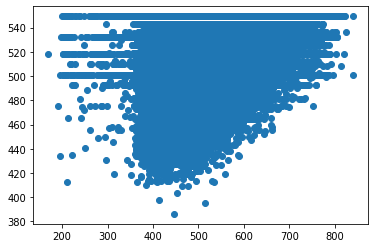

In [125]:
plt.scatter(df['Average score'], y_pred)

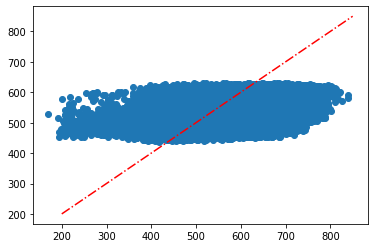

In [169]:
y_pred = mixed_lm.predict(df.loc[:, features])
plt.scatter(df['Average score'], y_pred)
plt.plot(np.linspace(200,850), np.linspace(200,850), '-.r')

In [ ]:
model.predict(reresult.random_effects["group1"], exog=xtest). 

In [160]:
mixed_lm.random_effects

{'AC': Group Var   -6.857987
 dtype: float64,
 'AL': Group Var   -0.669701
 dtype: float64,
 'AM': Group Var   -12.596008
 dtype: float64,
 'AP': Group Var   -13.636789
 dtype: float64,
 'BA': Group Var    0.858616
 dtype: float64,
 'CE': Group Var    0.518356
 dtype: float64,
 'DF': Group Var    5.176466
 dtype: float64,
 'ES': Group Var    12.17082
 dtype: float64,
 'GO': Group Var   -4.582853
 dtype: float64,
 'MA': Group Var   -9.34144
 dtype: float64,
 'MG': Group Var    18.984212
 dtype: float64,
 'MS': Group Var   -2.325707
 dtype: float64,
 'MT': Group Var   -8.66935
 dtype: float64,
 'PA': Group Var   -7.720304
 dtype: float64,
 'PB': Group Var    2.096646
 dtype: float64,
 'PE': Group Var    7.683181
 dtype: float64,
 'PI': Group Var    2.051279
 dtype: float64,
 'PR': Group Var    1.029878
 dtype: float64,
 'RJ': Group Var    9.600633
 dtype: float64,
 'RN': Group Var    8.378791
 dtype: float64,
 'RO': Group Var   -10.199316
 dtype: float64,
 'RR': Group Var   -2.943594
 dt

In [167]:
metrics.r2_score(df['Average score'], y_pred)

0.310696275224304

In [4]:
correlations = joblib.load("2022_corr_df.pkl")

In [5]:
R = abs(correlations['Average score']).sort_values(ascending = False)

In [153]:
R[5:15]

School type_Private    0.393106
School type_Public     0.393106
Q024_A                 0.392878
Q018_B                 0.318025
Q018_A                 0.318025
Q010_A                 0.316824
Q008_B                 0.315128
Q006_B                 0.314552
Ethinicity_1           0.280829
Q016_A                 0.280301
Name: Average score, dtype: float64